In [1]:
from lcode2dPy.simulation.interface import Simulation
from lcode2dPy.diagnostics.targets import BeamDiagnostics, PlasmaDiagnostics
from lcode2dPy.config.default_config import default_config
from lcode2dPy.beam.beam_generator import make_beam, Gauss, rGauss
import numpy as np
import matplotlib.pyplot as plt
import subprocess

In [2]:
# Параметры

time_step       = 200
time_limit      = 200.5
window_length   = 0.2
window_width    = 2
r_step          = 0.05
xi_step         = 0.05

In [3]:
!rm ../c_code/*

In [4]:
# Config
config = default_config
config.set('time-step', time_step)
config.set('time-limit', time_limit)
config.set('window-length', window_length)
config.set('window-width', window_width)
config.set('window-width-step-size', r_step)
config.set('xi-step', xi_step)

# Beam
gamma = 426
angspread = 1e-5
m_proton = 958/0.51

beam_pars = dict(xi_distr=Gauss(sigma=100, vmin=-window_length, vmax=0),
                r_distr=rGauss(vmin=0, vmax=window_width),
                ang_distr=Gauss(sigma=angspread, vmin=None, vmax=None),
                pz_distr=Gauss(gamma*m_proton, gamma*m_proton*1e-4, vmin=None, vmax=None),
                Ipeak_kA=2*40/1000,
                q_m=1/m_proton,
                saveto="../c_code")

diagnostics = [
    BeamDiagnostics(period=time_limit//time_step * time_step),
    PlasmaDiagnostics(period=time_limit//time_step * time_step)
]

sim = Simulation(beam_pars=beam_pars, diagnostics=diagnostics, config=config)

In [5]:
sim.step(int(time_limit//time_step))

Number of particles: 10093
Number of particles in the middle layer: 1261


In [6]:
# Готовим C диагностики
!rm ../c_code/*
!cp beamfile.bin ../c_code/beamfile.bin
config.c_config('../c_code/lcode.cfg')
!echo 0 > ../c_code/beamfile.bit 

p = subprocess.Popen(["/home/global/lcode/lcode", "lcode.cfg"], cwd="../c_code")
p.wait()

0

In [7]:
c_plasma=np.loadtxt('../c_code/00200.pls')
xis = np.arange(-xi_step,-window_length,-xi_step)
xis = np.unique(c_plasma.T[0])[::-1]
c_rs = np.array([c_plasma[c_plasma.T[0]==xi].T[2] for xi in xis])
plasma = diagnostics[1].data
py_pls = plasma[time_step]
py_rs = np.array([layer.r for layer in py_pls])

(0, 0.1)

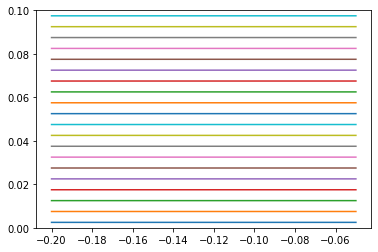

In [8]:
plt.plot(xis, c_rs);
plt.ylim(0, 0.1)

In [9]:
plt.plot(xis, py_rs);
plt.ylim(0, 0.1)

In [ ]:
diff = c_rs - py_rs
plt.plot(xis, diff);

Error: Kernel is dead